<a id='overview'></a>
# Overview

This notebook explores the [asteroid dataset](https://www.kaggle.com/datasets/sakhawat18/asteroid-dataset).

My approach here is very rudimentary. My primary focus is ***not*** with data science per se; rather, I am simply using this dataset as venue for learning about asteroids.  For example, instead of using the matchine learning tools to make predictions based on the dataset, I am simply slicing-and-dicing the dataset, and then using the various internet resources for understanding the trends being seen.

Several websites were aided me greatly in this endeavor
* [JPL Small-Body Database Search Engine](https://ssd.jpl.nasa.gov/tools/sbdb_query.html)
* [CNEOS - Center for Near-Earth-Object Studies](https://cneos.jpl.nasa.gov/)
* [Windows to the Universe](https://www.windows2universe.org/our_solar_system/planets_orbits_table.html)
* [The Planetary Mechanics Blob](http://planetary-mechanics.com/)

Table of Contents:
* [Overview](#overview)
* [Setup and Useful Tools](#setup)
* [Asteroid Classes](#classes)
    - [Introduction](#classes_introduction)
    - [Distribution Throughout the Solar System](#classes_distribution)
    - [Milankovitch Cycles](#classes_milankovitch)
    - [Mars Crossing Asteroids (MCA)](#classes_mca)
* [Kirkwood Gaps](#kirkwood)
    - [Overview](#kirkwood_overview)
    - [Inner vs Inner; Outer vs Outer](#kirkwood_inner_vs_inner)
* [Inclination from the Ecliptic](#inclination)
    - [Overview](#inclination_overview)
    - [Inner Main Belt Asteroids - the Hungaria](#inclination_hungaria)
    - [Mars Crossing Asteroids](#inclination_mca)

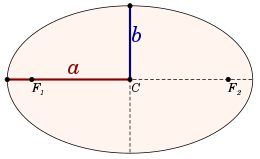# Basic Terminology 

When describing an ellipse 
* $a$ is the semi-major axis
* $b$ is the semi-minor axis
* $e = \sqrt{1-b^2/a^2}$ is the eccenticity of the ellipse
* the eccentricity of a circle is 0; that of an ellipse is between 0 and 1 
* $F_1$ and $F_2$ are the foci of the ellipse, located at $\pm ea$

With the simple two-body astronomical description of an orbit about the sun
* orbits are typically bounded (elliptical) or unbounded (hyperbolic)
* with elipitical orbits, the sun is located at one of the foci
* an elliptical orbit's *perihelion* $= a*(1-e)$ is its point of closest approach to the sun
* an elliptical orbit's *aphelion* $= a*(1+e)$ is its furthest point from the sun
* an elliptical orbit's period (in years) is related to its semi-major axis (in AU) as $p^2 = a^3$ (Kepler's Third Law)

*Note that the concept of eccentricity also applies to parabolas ($e = 1$) and hyperbolas ($e > 1$).*



<a id='setup'></a>
# Setup and Useful Utilities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_asteroids = pd.read_csv('/kaggle/input/asteroid-dataset/dataset.csv', low_memory=False)

In [2]:
from collections import namedtuple
Orbit = namedtuple("Orbit", "e a i")
planets = {
    "Mercury": Orbit(0.206,  0.3871,  7.00),
    "Venus":   Orbit(0.007,  0.7233,  3.39),
    "Earth":   Orbit(0.017,  1.0000,  0.00),
    "Mars":    Orbit(0.093,  1.5273,  1.85),
    "Jupiter": Orbit(0.048,  5.2028,  1.31),
    "Saturn":  Orbit(0.056,  9.5388,  2.49),
    "Uranus":  Orbit(0.046, 19.1914,  0.77),
    "Neptune": Orbit(0.010, 30.0611,  1.77),
    "Pluto" :  Orbit(0.248, 39.5294, 17.15)
    }

to_perihelion = lambda a,e : a * (1 - e)
to_aphelion = lambda a,e : a * (1 + e)

def to_cdf( df, col):
    MAX_STEPS = 40000
    cdf = df.sort_values(by=col).reset_index(drop=True)
    cdf['percentile'] = 100*(cdf.index+1)/len(cdf)
    skip = 1 if len(cdf) < MAX_STEPS else len(cdf)//MAX_STEPS
    return cdf[::skip]

<a id='classes'></a>
# Asteroid Classes

<a id='classes_introduction'></a>
## Introduction
One of the attributes of the asteroids in this dataset is an orbit *class* that appears to be quite interesting. The class is a three-character code which for me, at least, was a bit opaque. However, the [JPL Small-Body Database Search Engine](https://ssd.jpl.nasa.gov/tools/sbdb_query.html) provided a mechanism for converting the class code into an actual name for the orbit class, which could then be used for looking up a description in Wikipedia.  

The following table provides a summary of the orbit class, ordered by the distance of said class from the sun:

| Class | Name | Description |
| --- | --- | --- |
| IEO | [Arita](https://en.wikipedia.org/wiki/Atira_asteroid) | Resids wholly within the Earth's Orbit |
| ATE | [Aten](https://en.wikipedia.org/wiki/Aten_asteroid) | Earth-crossing Asteroids, residing mostly within Earth's orbit|
| APO | [Apollo](https://en.wikipedia.org/wiki/Apollo_asteroid) | Earth-Crossing Asteroids, residing mostly outside of Earth's Orbit |
| AMO | [Amor](https://en.wikipedia.org/wiki/Amor_asteroid) | Near-Earth asteroid residing entirely outside of Earth's orbit |
| MCA | [Mars Crossing Asteroid](https://en.wikipedia.org/wiki/List_of_Mars-crossing_minor_planets) | |
| IMB | [Inner Main-belt Asteroid](https://en.wikipedia.org/wiki/Asteroid_belt) | see section on Kirkwood Gap |
| MBA | [Main-belt Asteroid](https://en.wikipedia.org/wiki/Asteroid_belt) | see section on Kirkwood Gap |
| OMB | [Outer Main-belt Asteroid](https://en.wikipedia.org/wiki/Asteroid_belt) | see section on Kirkwood Gap |
| AST | Asteroid (other ) | |
| TJN | [Jupiter Trojan](https://en.wikipedia.org/wiki/Jupiter_trojan) | Share Jupiter's orbit; reside at the L4 or L5 Lagrange Points |
| CEN | [Centaur](https://en.wikipedia.org/wiki/Centaur_(small_Solar_System_body)) | A small solar system body between Jupiter and Neptune |
| TNO | [TransNeptunian Object](https://en.wikipedia.org/wiki/Trans-Neptunian_object) | Any minor planet that orbits at a greater average distance than Neptune |
| HYA | Hyberbolic Asteroid | |

The breakdown of the asteroids in the dataset by orbit class is as follows:

In [3]:
def summarize_by_class( df ):
    OrbitClass = {
        'AMO' : 'Amor',
        'APO' : 'Apollo',
        'AST' : 'Asteroid (other)',
        'ATE' : 'Aten',
        'CEN' : 'Centaur',
        'HYA' : 'Hyperbolic Asteroid',
        'IEO' : 'Atira',
        'IMB' : 'Inner Main-belt Asteroid',
        'MBA' : 'Main-belt Asteroid',
        'MCA' : 'Mars Crossing Asteroid',
        'OMB' : 'Outer Main-belt Asteroid',
        'TJN' : 'Jupiter Trojan',
        'TNO' : 'TransNeptunian Object'
        }

    _ = df['class'].value_counts()
    return pd.DataFrame({
        'class': _.index,
        'count': _,
        'orbit_class' : _.index.map( OrbitClass)
    }).reset_index(drop=True)

summarize_by_class(df_asteroids)

,class,count,orbit_class
0,MBA,855954,Main-belt Asteroid
1,OMB,28355,Outer Main-belt Asteroid
2,IMB,20360,Inner Main-belt Asteroid
3,MCA,18685,Mars Crossing Asteroid
4,APO,12687,Apollo
5,AMO,8457,Amor
6,TJN,8221,Jupiter Trojan
7,TNO,3468,TransNeptunian Object
8,ATE,1729,Aten
9,CEN,506,Centaur


Not surprisingly, the bulk of the asteroids in the dataset reside in the asteroid belt (MBA, OMB, and IMB). What I did find curious was the relatively high number of near earth asteroids in the dataset (MCA, APO, and AMO). A natural suspicion is that this reflects a "hometown" bias. There has been increasing interest in  near-earth objects recently spurred on by the discovery of the asteroid 1997 XF11 which was initially thought to be on a collision course with Earth. As shown on [JPL's Center for Near Earth Object Studies website](https://cneos.jpl.nasa.gov/stats/totals.html), there has since been exponential growth in the number of near-earth asteroids discovered.

The dataset itself hints at this bias. For example, if one computes for the various orbit classes the mean values of the semi-major axis $a$ (in AU) and the mean diameter (in km) of the asteroids, the asteroids appear to grow in size the farther away they lie! Either that, or we are simply better at discovering small asteroids if they are nearby.

In [4]:
df_asteroids[['a','diameter','class']].groupby('class').agg('mean').sort_values(by='a').dropna()

,a,diameter
class,,
ATE,0.888393,0.615705
APO,1.719038,0.955645
IMB,1.913861,2.299947
AMO,2.063581,1.752030
MCA,2.260557,3.328693
MBA,2.682745,5.096487
OMB,3.380913,8.781382
AST,5.055573,13.044125
TJN,5.199812,20.780553


<a id='classes_distribution'></a>
## Distribution Throughout the Solar System

Next, I would like to focus on asteroids that are bounded to the solar system, and examine how they are distributed amongst the planets. As one of my motivations for doing so was to get a feeling for the likelihood of planetary collision (and, in particular, collisions with the Earth!), I decided to present the data as a scatter plot based on the asteroid's *perihelion* and *aphelion* (closest and furthest approach to the sun). Also, as there are a wide variety of distances involved, it is convenient to display the data on a log-log plot.

Three different views of the asteroids are presented below
* first, we simply display the full set of bound orbits
* next, we zoom in on those whose perihelion lies inside of the Earth's orbit
* finally, we zoom in on those which reside between Earth and Jupiter

In [5]:
ellipticals = df_asteroids[ df_asteroids['class'] != "HYA"][['a','e','class']]
ellipticals['perihelion'] = to_perihelion( ellipticals.a, ellipticals.e )
ellipticals['aphelion'] = to_aphelion( ellipticals.a, ellipticals.e )

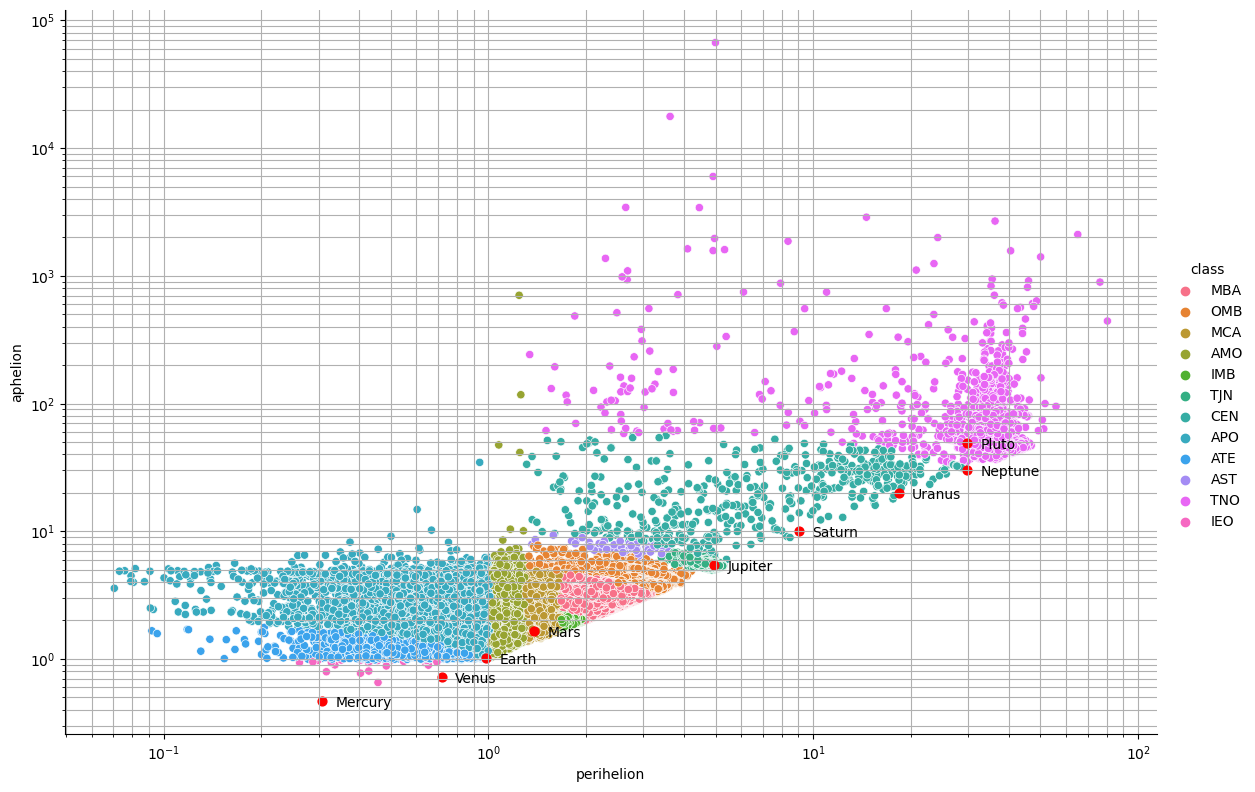

In [6]:
def plot_planets(names=planets.keys(), params=(1,1,200)):
    ax = plt.gca()
    scale_x, scale_y, size = params
    for name in names:
        orbit = planets[name]
        perihelion = to_perihelion( orbit.a, orbit.e)
        aphelion = to_aphelion( orbit.a, orbit.e)
        plt.scatter( perihelion, aphelion, c='red', s=size)
        plt.text( scale_x*perihelion, scale_y*aphelion, name)

sns.relplot( data=ellipticals, x='perihelion',y='aphelion', hue='class', height=8, aspect=12/8)
plot_planets(params=(1.1,0.9,40))

plt.minorticks_on()
plt.grid(which='both')
plt.xscale('log')
plt.yscale('log')

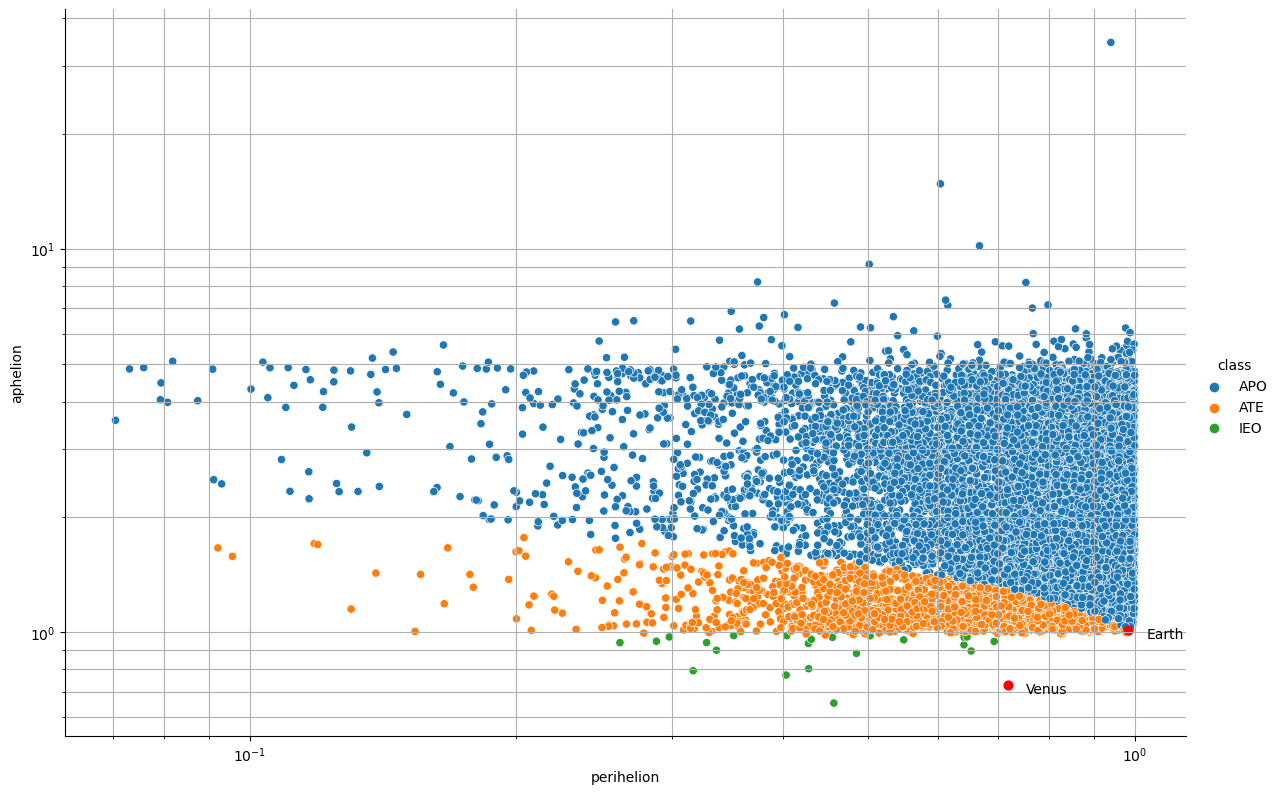

In [7]:
inner=ellipticals[ellipticals.perihelion < 1]
sns.relplot( data=inner, x='perihelion',y='aphelion', hue='class', height=8, aspect=12/8)
plot_planets( ['Venus', 'Earth'], params=(1.05, 0.95, 40))
plt.minorticks_on()
plt.grid(which='both')
plt.xscale('log')
plt.yscale('log')

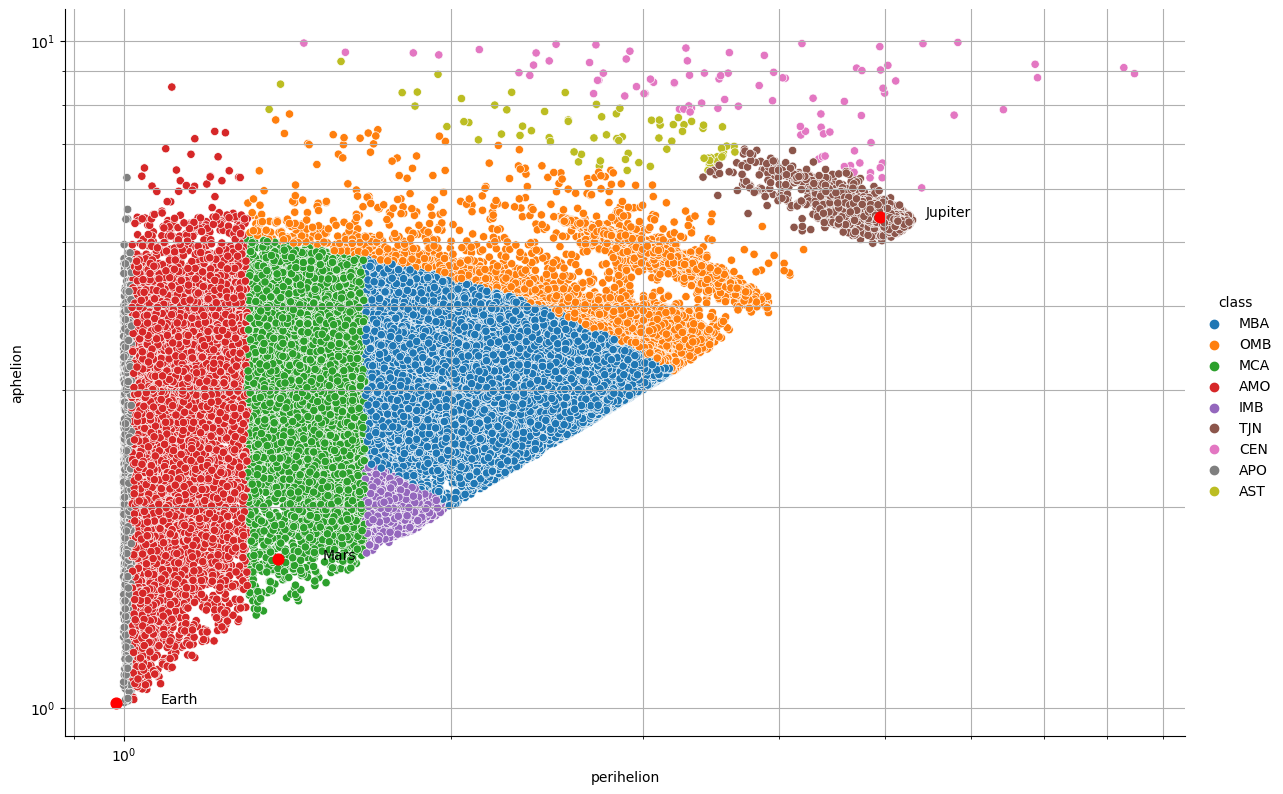

In [8]:
mid = ellipticals[ 
    (ellipticals.perihelion > 1) & 
    (ellipticals.perihelion < 10) &
    (ellipticals.aphelion < 10)
    ]
sns.relplot( data=mid, x='perihelion',y='aphelion', hue='class', height=8, aspect=12/8)
plot_planets( ['Earth','Mars','Jupiter'], params=(1.1, 1, 60))
plt.minorticks_on()
plt.grid(which='both')
plt.xscale('log')
plt.yscale('log')

These plots clearly display the *geometric* aspect of the asteroid orbit classification scheme.  In particular, as the classes were designed to characterize the position of the within the solar system and the proximity of the planets, the clustering of the classes in the above plots simply reflects, to a large extent, the design of classification scheme. This strongly suggests that a simple K-Nearest Neighbor approach to predicting the orbit class based on aphelion and perihelion should work pretty well!

There are several other items I would like to point out from these plots.

First, by definition
* a circular orbit is one where the aphelion is equal to the perihelion
* with an elliptical orbit, the aphelion will be greater than the perihelion
* the greater the eccentricity, the greater the differnce (well, ratio) between the aphelion and perihelion

With that in mind, the graph shows that
1. The orbits of the planets are all fairly circular (*aphelion* $\approx$ *perihelion*)
2. Mercury and Pluto are the outliers, deviating the furthest from circular
3. The orbits of the asteroids are typically much more elliptical than the planets

Second, from the viewpoint of possible collisions with the Earth, the Apollos (APO) and Atens (ATE) are the worrisome groups. These are the Earth-crossers - the ones whose perihelion lies inside the Earth's orbit, but whose aphelion lies outside. Graphically speaking, this is evidenced in the second plot by these groups being the ones whose orbits lie to the left (*perihelion* $<$ *Earth*) and above (*aphelion* $>$ *Earth*) the Earth's position in the plot.

Third, there are very few asteroids that lie wholey within the Earth's orbit (i.e., the IEO, aka the Atiras). I do not know if there is a physical reason for this (e.g., a nearby passage of the Earth would typically perturb the orbit, promoting an Atira into an Aten), or if this is simply observational bias. 


<a id='classes_milankovitch'></a>
## Milankovitch Cycles

In the comment above, I implied that *potential hazardous asteroids* were the Earth-crossers - i.e., ath Apollos (APO) and the Atens (ATE).  While those groups are potential hazardous, are they the only ones?  This is easy to check.

In [9]:
print("Counts of Apollos and Atens")
display( df_asteroids['class'].value_counts()[ ['APO', 'ATE'] ] )

print("\nCounts of Potentially Hazardous Asteroids")
PHAs = df_asteroids[ (df_asteroids.pha == 'Y')][['class', 'e','a']]
display( PHAs['class'].value_counts())

Counts of Apollos and Atens


APO    12687
ATE     1729
Name: class, dtype: int64


Counts of Potentially Hazardous Asteroids


APO    1768
ATE     174
AMO     118
IEO       6
Name: class, dtype: int64

The first thing to note in these statistics is that not all Earth-crossers are deemed potentially hazardous. According to the dataset, only about 14% of the Atens and Apollos merit the *potentially hazardous asteroid* distinction. This seems reasonable, as according to [CNEOS](https://cneos.jpl.nasa.gov/glossary/PHA.html) an asteroid is deemed potentially hazardous only if it is sufficiently large and its orbit brings it sufficiently close to the Earth.

What I found more curious, though, was the apperance of some Atiras (IEO) and Amors (AMO) in this list. Neither of these classes are Earth-crossers; the Atiras lie wholly inside the Earth's orbit, and the Amors lie wholly outside. Why would they be deemed potentially hazardous?

I believe that the answer to this latter question lies with understanding the impact of the [Milankovitch cycles](https://www.earthdate.org/episodes/earths-odd-orbit). In particular, the eccentricity of the Earth's orbit is not constant. Rather, due to the gravitational tugs on Earth from the various planets, the Earth's eccentricity varies over time, ranging from nearly circular ( $e_{min} = 0.000055$) to a maximum value of $e_{max} = 0.0679$. Currently, the eccentricity is $e = 0.0167$, but it will reach its maximum value in about 200,000 years.

As such, while the Atiras (IEO) and Amors (AMO) are not ***currently*** Earth-crossers, the Atiras with an *aphelion* $> (1-e_{max})$ and the Amors with a *perihelion* $< (1+e_{max})$ ***will become*** Earth-crossers in the next 200,000 years - and thus enter the realm of potentially hazardous asteroids.


<a id='classes_mca'></a>
## Mars Crossing Asteroids (MCA)

Next, I would like to at the asteroids classified as belonging to the MCA orbit class. In particular, I was interested in understanding the demarcations of the boundaries for this class and the position of Mars on the graph relative to the MCAs.  With this latter point in particular, I found it curious that Earth was found at the lower, right-hand corner of the Earth-crossors (the Apollos and Atens), while Mars both *embedded within* the Mars-crosses, and closer to the lower, *left*-hand corner of the group.

To gain an understanding, I have found it helpful to slightly enhance the third plot above by
* adding a line denoting the circular orbits ( *perihelion = aphelion*)
* marking on that line Mars' perihelion (point A)
* also marking on that line Mars' aphelion (point B)

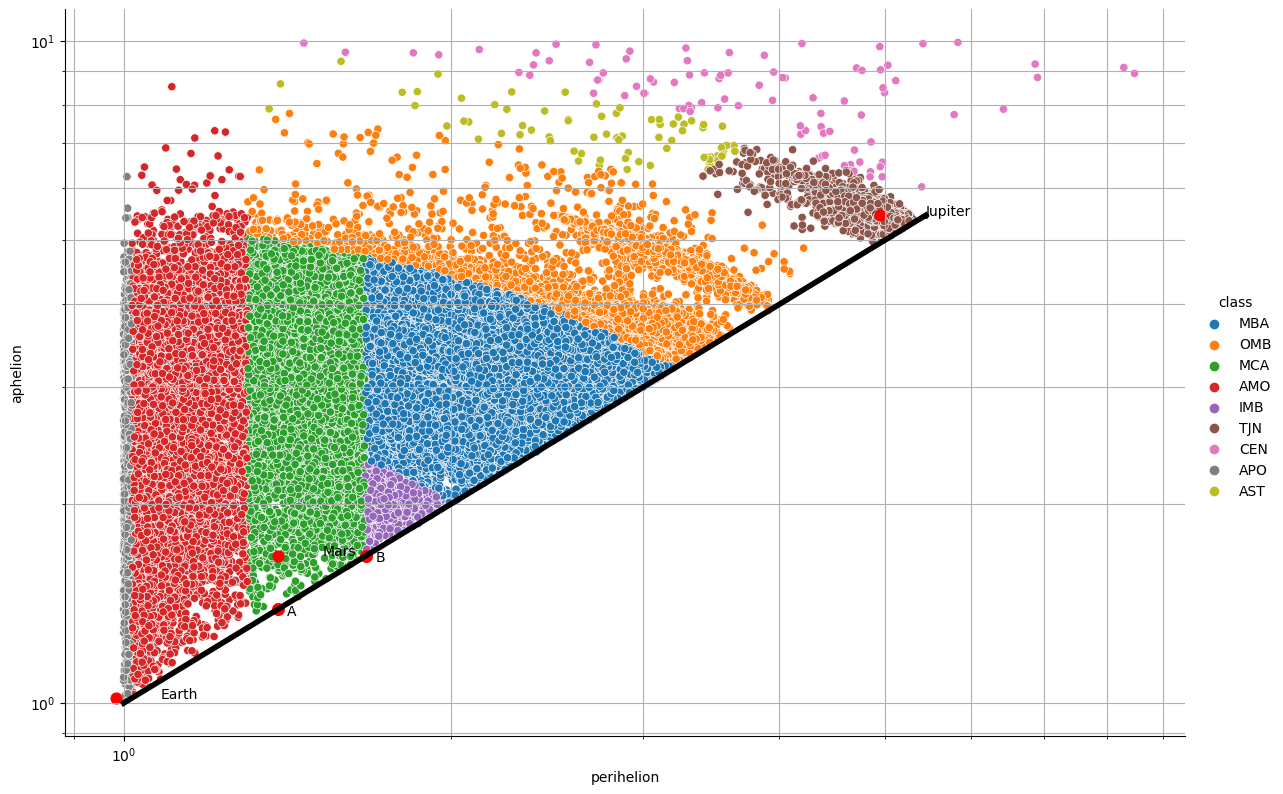

In [10]:
def add_point( x, y, text, size=70):
    plt.scatter( x, y, c='red', s=size)
    plt.text( 1.02*x, 0.98*y, text)
    
sns.relplot( data=mid, x='perihelion',y='aphelion', hue='class', height=8, aspect=12/8)
plot_planets( ['Earth','Mars','Jupiter'], params=(1.1, 1, 60))

X = [1, to_aphelion( planets['Jupiter'].a, planets['Jupiter'].e)]
plt.plot( X, X, color='black', lw=4)

mars_perihelion = to_perihelion( planets['Mars'].a, planets['Mars'].e )
mars_aphelion = to_aphelion( planets['Mars'].a, planets['Mars'].e )
add_point( mars_perihelion, mars_perihelion, 'A')
add_point( mars_aphelion, mars_aphelion, 'B')

plt.minorticks_on()
plt.grid(which='both')
plt.xscale('log')
plt.yscale('log')

Now, one of the defining characteristics of a Mars Crossing Asteroid (MCA) is that it crosses the orbit of Mars! Geometrically speaking, this means that means that the orbit's 
1. aphelion is larger than Mars' perhelion (it doesn't lie completely inside of Mars' orbit)
2. perihelion is smaller than Mars' aphelion (it doesn't lie completely outside of Mars' orbit)

Graphically speaking, item 1 means the orbit lies above point A, while item 2 means the orbit lies to the left of point B.  Anything above point A and to the left of point B crosses the orbit of Mars.

*Note that the description of the Earth-crossers was simpler due to the fact that the Earth's orbit is much more ciruclar than Mars'. So, for the Earth-crossers, point A $\approx$ point B $\approx$ Earth's poisition on the graph.*

This description clarifies the right-hand boundary of the MCAs, but what about the left-hand boundary? A slightly different way to ask that question is to note that most of the Amors (AMO) seem to be crossing the orbit of Mars - they are above point A and to the left of point B. Why aren't they classified as MCA?

The answer lies basically with how the classification scheme deals with ambiguities. Prescriptively speaking, the classification scheme provides a series of criteria on a class designed to remove ambiguities; practically speaking, the scheme imposes a hierachy on the attributes.  For example
* the Amors (AMO) are near-earth object (*perihelion < 1.3AU*) that lie outside of Earth's Orbit
* the Mars Crossing Asteroids (MCA) have an orbit that crosses the orbit of Mars
* if an asteroid meets both requirements, the AMO attribute trumps

<a id='kirkwood'></a>
# Kirkwood Gaps
<a id='kirkwood_overview'></a>
## Overview
The main belt asteroids sit between Mars and Jupiter.  Their orbits are strongly influenced by Jupiter, with one of the more famous dynamical features being the [Kirkwood Gaps](https://en.wikipedia.org/wiki/Kirkwood_gap).  When the distribution of the asteroids is viewed as a function of the semi-major axis, there are certain positions at which there is a dearth of orbits.

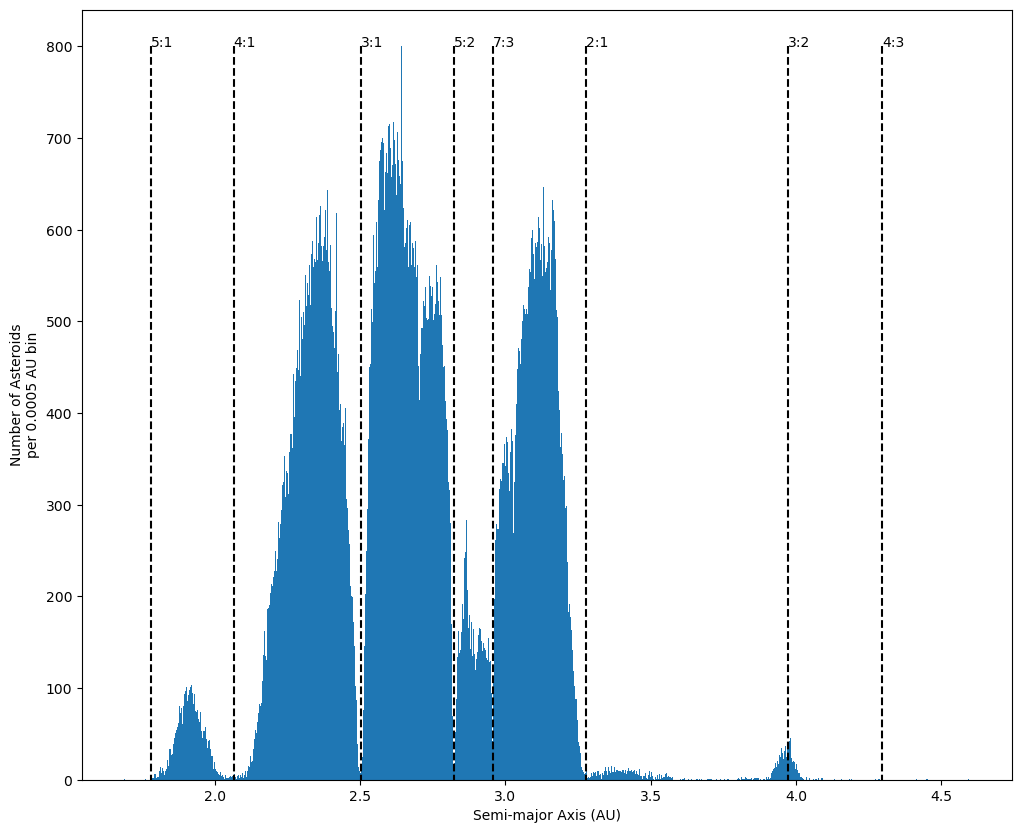

In [11]:
asteroid_belt = df_asteroids[ df_asteroids['class'].isin(['IMB','MBA','OMB'])]
fig, ax = plt.subplots( figsize=(12,10), facecolor='white')

# ################################################################
# First, simply display a histogram of the asteroid distribution.
# Choose the bin-width for the semi-major axis to match that which
# appears in the wikipedia page on the Kirkwood Gaps
# ################################################################
bin_width = 0.0005
min_a = asteroid_belt.a.min()
max_a = asteroid_belt.a.max()
bins = np.arange( min_a, max_a, bin_width)
y, x, _ = plt.hist( asteroid_belt.a, bins=bins)
plt.xlabel('Semi-major Axis (AU)')
plt.ylabel(f'Number of Asteroids\nper {bin_width} AU bin')
peak_bin_height = y.max();

# ################################################################
# Next, denote position of the Kirkwood Gaps
# ################################################################
Kirkwood_Gap = namedtuple( "Kirkwood_Gap", "a desc")
gaps = [
    Kirkwood_Gap( 1.780, "5:1"),
    Kirkwood_Gap( 2.065, "4:1"),
    Kirkwood_Gap( 2.502, "3:1"),
    Kirkwood_Gap( 2.825, "5:2"),
    Kirkwood_Gap( 2.958, "7:3"),
    Kirkwood_Gap( 3.279, "2:1"),
    Kirkwood_Gap( 3.972, "3:2"),
    Kirkwood_Gap( 4.296, "4:3")
    ]
for gap in gaps:
    plt.plot( [gap.a, gap.a], [peak_bin_height, 0], 'k--')
    plt.text( gap.a, peak_bin_height, gap.desc)

The dynamical origin of the Kirkwood gaps is fairly straightforward. Recall that according to [Kepler's Third Law](https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion), there is a simple relationship between an orbit's period and its semi-major axis, $p^2 = a^3$, where the period $p$ is measured in years and the semi-major axis $a$ is measured in astronomical units AU.  The Kirkwood gaps appear at points where there is a resonance between the asteroid's period of motion and that of Jupiter. For example, if an asteroid were to be found in the 3:1 Kirkwood gap, it would have a period of motion 3 times that of Jupiter's.

That resonance is key to understanding the gap. Let's say that we have an asteroid in the asteroid belt that starts off in a slightly eliptical orbit. Since the asteroid belt lies inside of Jupiter's orbit, the asteroids are moving faster than Jupiter. Every time this asteroid passes Jupiter, it gets a gravitational tug from Jupiter, slightly perturbing the orbit. That tug could make the orbit either more or less eliptical, depending on where the asteroid is in its orbit.  If the period of the asteroid was incommensurate with Jupiter's, one might expect the effects of the various tugs to average out overtime. However, if the asteroid's period was a simple multiple of Jupiter's (as in the 3:1 Kirkwood Gap), the tugs would effectively be a resonant kick, pushing the asteroid into wildly oscillating (e.g., ever more eliptical) orbit, eventually sweeping the asteroid out of Kirkwood Gap.

<a id='kirkwood_inner_vs_inner'></a>
## Inner vs Inner; Outer vs Outer
The wikipedia page on the [Kirkwood Gap](https://en.wikipedia.org/wiki/Kirkwood_gap) has a much prettier of the above diagram, including coloration to show how the Kirkwood gaps are used to define
* inner main-belt asteroids ($a < 2.5AU$)
* intermediate main-belt asteroids  ($2.5AU < a < 2.82AU$)
* outer main-belt asteroids ($a > 2.82AU$)

![picture](https://upload.wikimedia.org/wikipedia/commons/d/d3/Kirkwood_Gaps.svg)

which seems to naturally align with our dataset's class definitions
* IMB = Inner Main-Belt 
* MBA = Main-Belt Asteroid
* OMB = Outer Main-Belt

... except it doesn't!

This is most clearly seen by examining the boundaries in the dataset for the semi-major axis of the three class:

In [12]:
for kls in [ 'IMB', 'MBA', 'OMB']:
    min_a = asteroid_belt[ asteroid_belt['class'] == kls].a.min()
    max_a = asteroid_belt[ asteroid_belt['class'] == kls].a.max()
    print(f"class={kls} min={min_a:.2f} max={max_a:.2f}")

class=IMB min=1.69 max=2.00
class=MBA min=2.00 max=3.20
class=OMB min=3.20 max=4.60


The wikipedia/picture article describes
* the blue group as the inner main-belt asteroids
* the orange group as the intermediate main-belt asteroids
* the green group as the outer-maint belt asteroids

From the dataset, though
* the IMB do not even appear in the wikipedia picture
* everything in the wikipedia picture to the left of 3.2AU is deemed MBA
* the boundary between the MBA and OMB sits slightly to the left of the 2:1 resonance - i.e., in the middle of the green group

I suspect these discrepencies are due either to different classification schemes being employed or evolving standards in the clasification scheme (note that the Wikipedia page was first written over 20 years ago!). In this vein, I did find an intersting [blog post](https://vissiniti.com/asteroid-classification/) discussing the history of schemes used for classifying asteroids by their spectral properties.

<a id='inclination'></a>
# Inclination from the Ecliptic
<a id='inclination_overview'></a>
## Overview

To me, the possibility of a collision between an asteroid and a planet is intrisically interesting. As such, I was interested in taking a quick look at the distribution of orbital inclinations, assuming that the further the further an orbit lay from the ecliptic the less likely a collision would be.

As can be seen in [the setup](#setup), the orbits of most of the planets lie within a couple of degrees of the ecliptic. The exceptions being Mercury at $7^{\circ}$ and Pluto at $17.15^{\circ}$.  There are not many asteroids that approach Mercury, and Pluto... well... is Pluto. For the remainder, the question then becomes what fraction of the asteroids lie within a few degrees of the ecliptic. 

To answer this, I calculated the [cumulative distribution function (CDF)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the various asteroid classes as a function of the inclination. Personally, I prefer using a CDF over the probability distribution (as visualized via a histogram) as CDFs are trivial to calculate and avoid the arbitrary binning process needed to create a histogram.

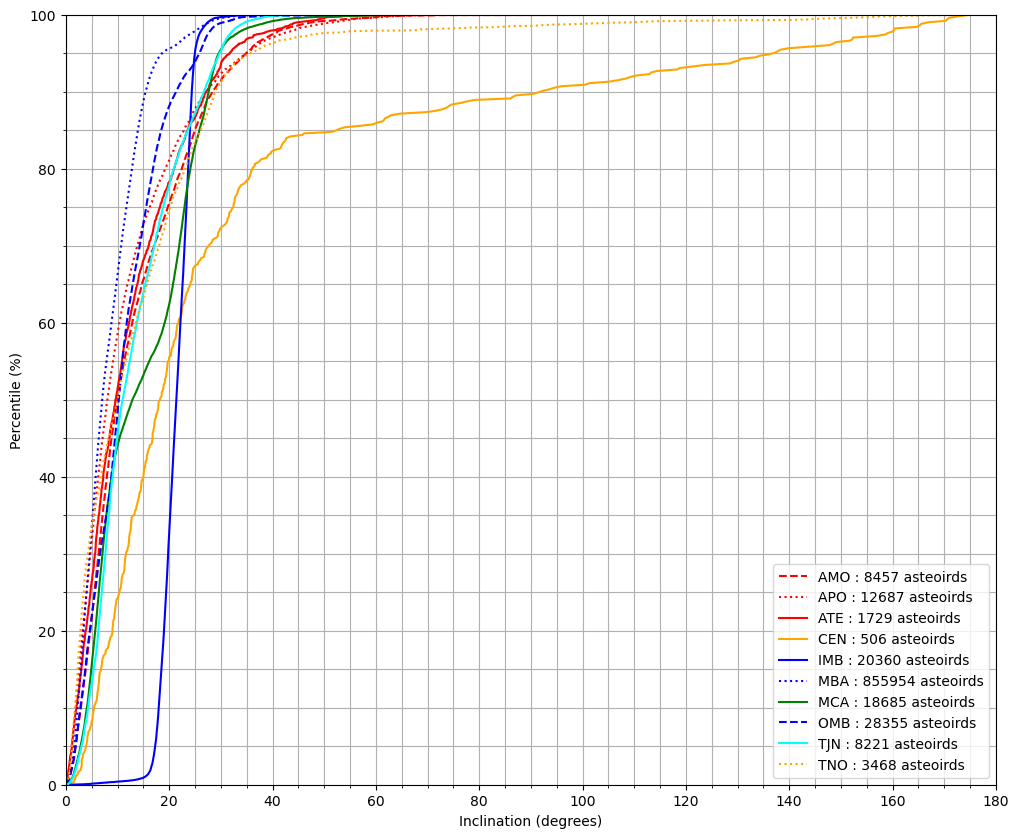

In [13]:
line_attr = namedtuple( 'line_attr', 'color style' )
styles = {
    'ATE': line_attr('red','solid'),
    'APO': line_attr('red','dotted'),
    'AMO': line_attr('red','dashed'),
    'MCA': line_attr('green','solid'),
    'IMB': line_attr('blue', 'solid'),
    'MBA': line_attr('blue', 'dotted'),
    'OMB': line_attr('blue', 'dashed'),
    'TJN': line_attr('cyan', 'solid'),
    'CEN': line_attr('orange','solid'),
    'TNO': line_attr('orange','dotted')
    }

fig, ax = plt.subplots( figsize=(12,10))
for kls, group in df_asteroids.groupby('class'):
    if kls not in styles:
        continue
    label = f"{kls} : {len(group)} asteoirds"
    c = styles[kls].color
    ls = styles[kls].style
    to_cdf( group, 'i').plot(ax=ax, x='i', y='percentile', c=c, ls=ls, label=label)

plt.minorticks_on()
plt.grid(which='both')
plt.xlabel('Inclination (degrees)')
plt.ylabel('Percentile (%)')
plt.xlim(0,180)
plt.ylim(0,100);

My read of these graphs is as follows - with the observations ordered from least interesting to most (at least to me):

1. The asteroids are typically spread further from the ecliptic than the planets. At most 30% of the asteroids for each class lie within $5^{\circ}$ of the ecliptic.
2. The asteroids outside of Jupiter's orbit (the CENs and TNOs) have much larger outliers than those within Jupiter's orbit
3. The Mercury Crossing Asteroids (MCA) show a strong bimodal distribution - half seem to be clustered at low inclinations, with a median of ${\sim}5^{\circ}$, and the other half clustered at a much higher inclination of ${\sim}25^{\circ}$. 
4. The inner main belt asteroids (IMB) are bizarre.  They lie completely outside of the ecliptic; instead, they appear to be tightly clustered around an inclination of ${\sim}22^{\circ}$.

<a id='inclination_hungaria'></a>
## Inner Main Belt Asteroids - the Hungaria

The explanations I have been able to find for the unusual inclinations of the IMB have focused on the [Hungaria Group](https://en.wikipedia.org/wiki/Hungaria_asteroids). To be perfectly frank, I do not know if phrase *Hungaria Group* is a synonym for IMB, or if the Hungaria group of asteroids is simply a major component of the IMBs. I would note that the orbital properties (inclination, eccentricity, semi-major axis) of the IMB as seen in the dataset (see plots below) match the description of the Hungaria group in the [Wikipedia page](https://en.wikipedia.org/wiki/Hungaria_asteroids):
* Low eccentricity of below 0.18
* An inclination of $16^{\circ}$ to $34^{\circ}$
* Semi-major axis between 1.78 and 2.00 AU

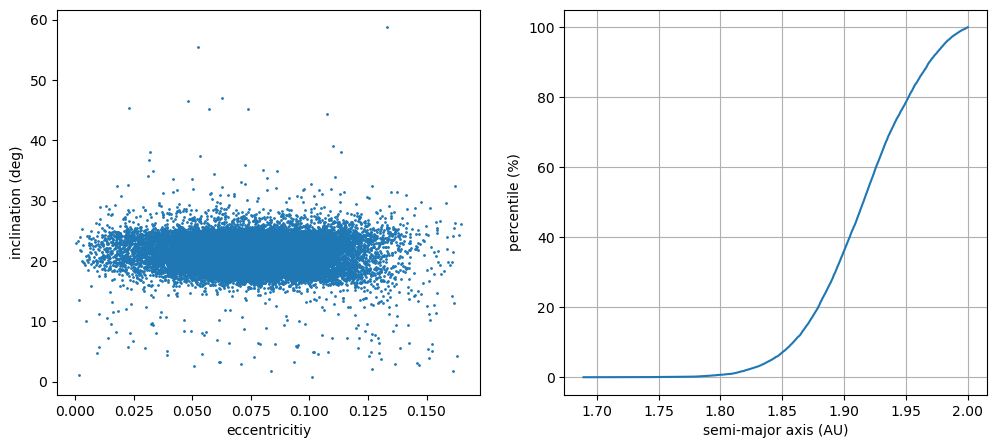

In [14]:
fig, axes = plt.subplots( 1,2, figsize=(12,5), facecolor='white')
imb = df_asteroids[ df_asteroids['class'] == 'IMB']
imb.plot( ax=axes[0], kind='scatter', s=1, x='e', y='i')
axes[0].set_xlabel('eccentricitiy')
axes[0].set_ylabel('inclination (deg)')

to_cdf( imb, 'a').plot( ax=axes[1], x='a', y='percentile', legend=None)
axes[1].set_xlabel('semi-major axis (AU)')
axes[1].set_ylabel('percentile (%)')
axes[1].grid(which='both')

If an IMB asteroid were to be found in the ecliptic, it would be close enough to Mars that the cumulative pertubations to the orbit over the lifetime of the Solar System due to Mars' influence would be enough to expel the asteroid. Only away from the ecliptic is Mars' influence small enough to allow the asteroids to remain unperturbed.

<a id='inclination_mca'></a>
## Mars Crossing Asteroids

As noted above, the inclinations for Mars Crossing Asteroids (MCA) appeared to be distributed in a bimodal fashion, with roughly half showing low inclinations and the other half appearing at similar inclindations to the Hungaria. It seems natural to wonder if perhaps the dynamical explanation for the high inclination of the Hungaria crosses the somewhat artifical boundary between the MCA and IMB asteroids. 

To this end, the following diagram is a scatter plot of the MCA, showing the distribution of the semi-major axis versus inclination.  On top of this is plotted a sample of the IMB in order to show how the placement of the IMB compares to the MCA.

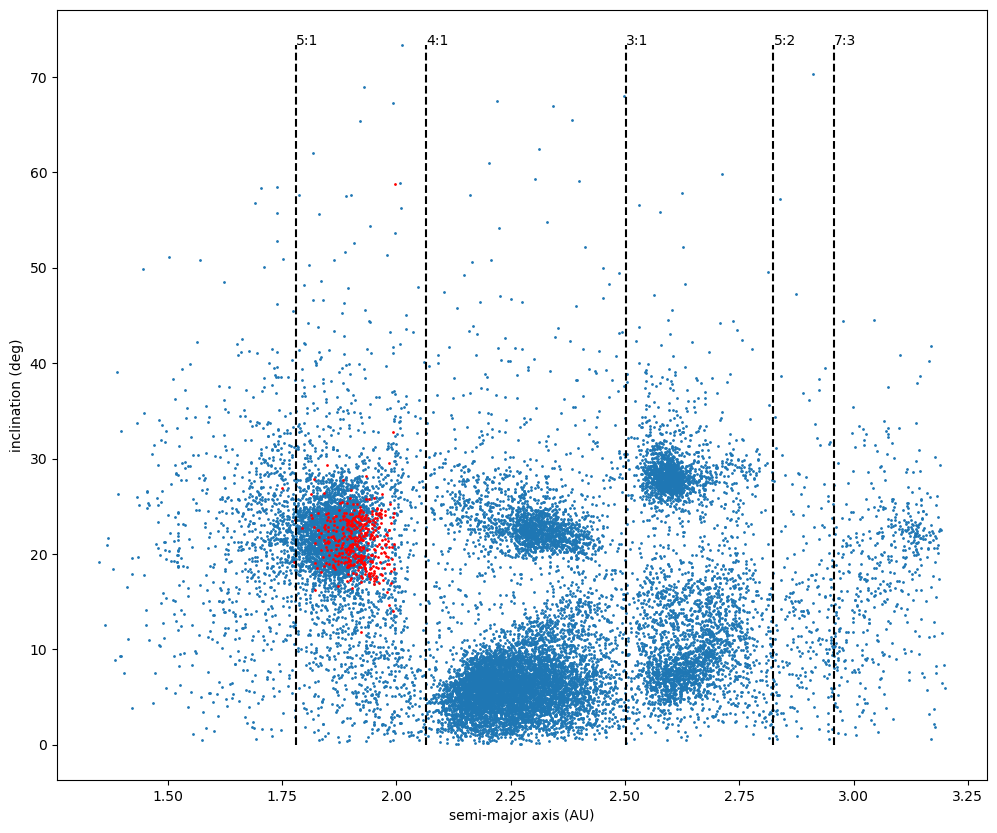

In [15]:
mca = df_asteroids[ df_asteroids['class'] == 'MCA']

fig, ax = plt.subplots( figsize=(12,10))
mca.plot(ax=ax, kind='scatter', s=1, x='a', y='i' )
imb.sample(frac=0.02).plot(ax=ax, kind='scatter', s=1, x='a', y='i', c='r' )

# #########################################
# Add in the positions of the Kirkwood Gaps
# #########################################
max_a = mca.a.max()
min_a = mca.a.min()
i_max = mca.i.max()
for gap in gaps:
    if min_a <= gap.a <= max_a:
        plt.plot( [gap.a, gap.a], [0,i_max], "k--")
        plt.text(gap.a, i_max, gap.desc)
        
ax.set_xlabel('semi-major axis (AU)')
ax.set_ylabel('inclination (deg)');

This is sort of a fun diagram! It clearly shows clustering of the MCA, with one of the larger clusters falling right on top of the IMB. To at least a novice like me, this strongly suggests that the MCAs laying interior of the 4:1 gap and the IMB have a common dynamical origin (or, at least, are governed by a common dynamical explanation). The basic difference between these two groups is in their eccentricities (not showing on the above digram) - with the MCAs having the larger eccentricity, thus "causing" them to cross Mars' orbit.  This is shown in the diagram below - a similar diagram to the above, save that the *inclination* is replaced with *eccentricity*

Now, the following is pure speculation, but...the placement of the three "upper" clusters (between $20^{\circ}$  and $30^{\circ}$) in the above diagram hints that perhaps they have a common origin but are subject to competing dynamical processes - the dynamical explanation of the Hungaria applying to all three clusters and in fact ***could*** apply in between the clusters, save that the resonances with Jupiter's orbit punch out the the holes / gaps. 

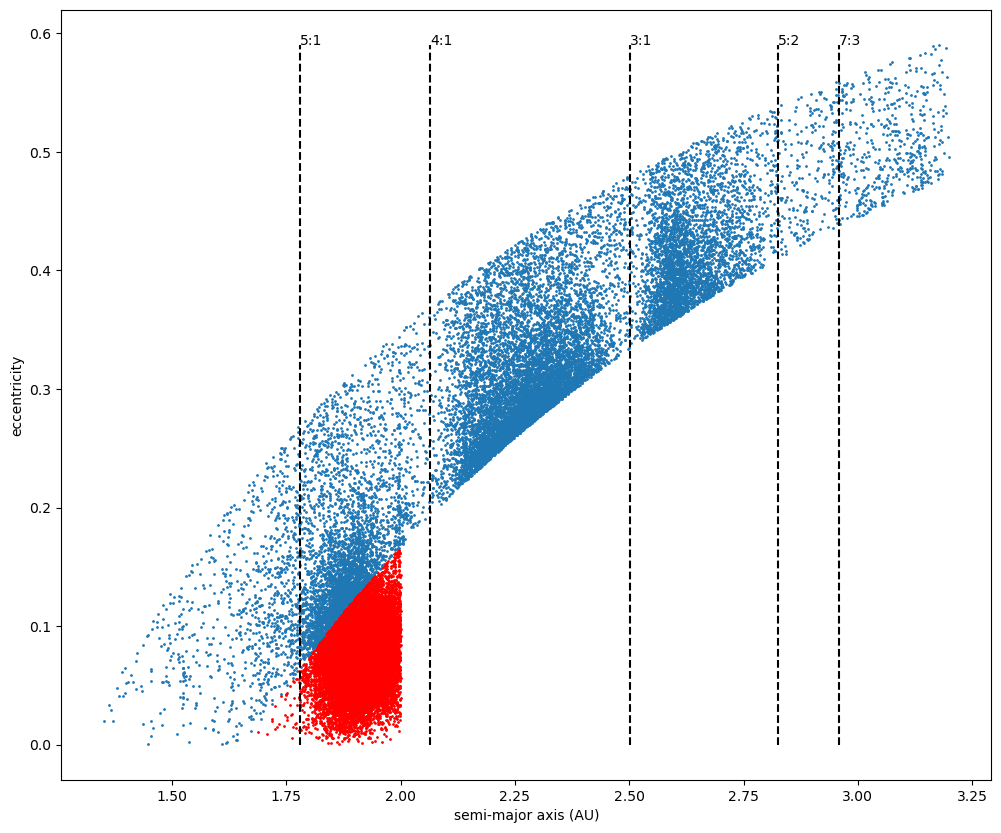

In [16]:
fig, ax = plt.subplots( figsize=(12,10))
mca.plot(ax=ax, kind='scatter', s=1, x='a', y='e' )
imb.plot(ax=ax, kind='scatter', s=1, x='a', y='e', c='r' )

# #########################################
# Add in the positions of the Kirkwood Gaps
# #########################################
max_a = mca.a.max()
min_a = mca.a.min()
e_max = mca.e.max()
for gap in gaps:
    if min_a <= gap.a <= max_a:
        plt.plot( [gap.a, gap.a], [0,e_max], "k--")
        plt.text(gap.a, e_max, gap.desc)
        
ax.set_xlabel('semi-major axis (AU)')
ax.set_ylabel('eccentricity');